# FYS4460 - Project 1: Introductory Molecular Dynamics Modeling
Author: Øyvind Sigmundson Schøyen

In this project we'll explore modelling of molecular systems. We'll start our initial study by looking at Argon atoms.

In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from read_lammps_dump import read_dump

sns.set()

Initially we read in data from a lammps simulation.

In [9]:
df = read_dump(os.path.join("velocity-distribution", "dump.lammpstrj"))

In [10]:
df.head()

,id,type,x,y,z,vx,vy,vz
0,1,1,0.00000,0.0,0.0,1.012100,0.213251,0.089516
1,5,1,7.36806,0.0,0.0,-0.153176,1.079850,0.001031
2,9,1,14.73610,0.0,0.0,-0.720942,-2.585440,-0.917600
3,13,1,22.10420,0.0,0.0,-2.083530,1.666840,0.965032
4,17,1,29.47230,0.0,0.0,-2.568510,-2.529350,-2.628410


Next we compute the total magnitude of the velocity

\begin{align}
    v = \sqrt{v_x^2 + v_y^2 + v_z^2}.
\end{align}

In [11]:
df["v"] = np.sqrt(df["vx"] ** 2 + df["vy"] ** 2 + df["vz"] ** 2)

In [5]:
df.head()

,id,type,x,y,z,vx,vy,vz,v
0,1,1,0.00000,0.0,0.0,1.012100,0.213251,0.089516,1.038189
1,5,1,7.36806,0.0,0.0,-0.153176,1.079850,0.001031,1.090660
2,9,1,14.73610,0.0,0.0,-0.720942,-2.585440,-0.917600,2.836591
3,13,1,22.10420,0.0,0.0,-2.083530,1.666840,0.965032,2.837383
4,17,1,29.47230,0.0,0.0,-2.568510,-2.529350,-2.628410,4.461322


In order to differentiate between the different timesteps we create a column for timesteps and add a timestep index.

In [6]:
df["timestep"] = 0

In [7]:
num_timesteps = 501
num_atoms = 4000

for i in range(num_timesteps):
    df.loc[i * num_atoms:(i + 1) * num_atoms, "timestep"] = i

In [100]:
df.tail()

,id,type,x,y,z,vx,vy,vz,v,timestep
2003995,2146,1,20.6496,70.5749,72.5053,-1.441580,0.016375,1.677140,2.211610,500
2003996,2998,1,22.3193,72.7661,73.1262,-0.774966,-1.859060,-0.652021,2.117028,500
2003997,71,1,38.6321,72.0330,73.1013,0.126816,-0.569508,-0.575847,0.819769,500
2003998,1433,1,67.9368,73.1790,72.2959,-2.354610,1.715020,-0.330291,2.931650,500
2003999,980,1,70.9225,73.3010,72.1290,0.398853,-3.297080,2.541540,4.182015,500


## Velocity distribution

According to the central limit theorem, the velocity distribution of the particles will move towards a Maxwell-Boltzmann distribution independent of the initial conditions. __(TODO: Explain the theory behind this)__. We test this statement by initializing our particles with a uniform velocity distribution. We give all particles $i$ a velocity vector $\mathbf{v}_i$ where each component $\mathbf{v}_i = (v^i_x, v^i_y, v^i_z)$ are $v^i_j \in [-2.5, 2.5]$ uniformly drawn. We can see this by visualizing the velocity distribution of each component the particles in the initial timestep.

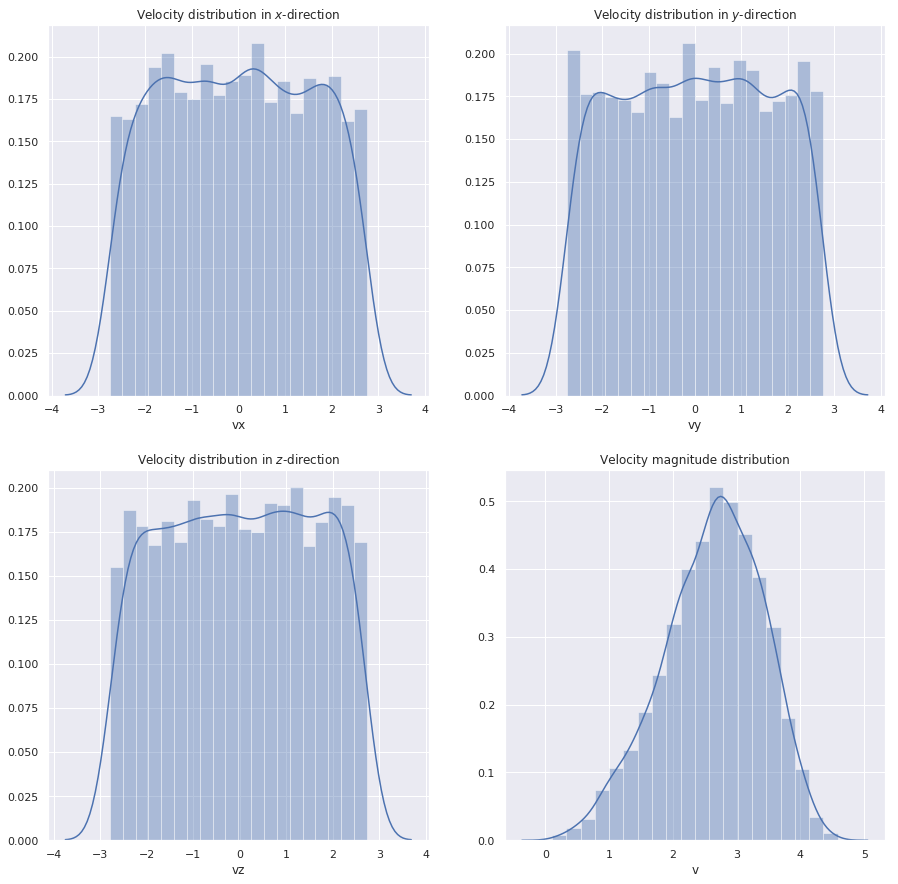

In [41]:
num_bins = 20

fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
sns.distplot(df.iloc[:num_atoms].vx, bins=num_bins)
plt.title(r"Velocity distribution in $x$-direction")

plt.subplot(2, 2, 2)
sns.distplot(df.iloc[:num_atoms].vy, bins=num_bins)
plt.title(r"Velocity distribution in $y$-direction")

plt.subplot(2, 2, 3)
sns.distplot(df.iloc[:num_atoms].vz, bins=num_bins)
plt.title(r"Velocity distribution in $z$-direction")

plt.subplot(2, 2, 4)
sns.distplot(df.iloc[:num_atoms].v, bins=num_bins)
plt.title(r"Velocity magnitude distribution")

plt.show()

We see that the components are seemingly uniform in their velocity distribution within $[-2.5, 2.5]$. The radial, or magnitude of the velocities, does not exhibit the same uniformity. Next we check the velocity distribution at the final timestep to see if we've reached a Maxwell-Boltzmann distribution. __(TODO: Expand on this theory: https://en.wikipedia.org/wiki/Uniform_distribution_(continuous))__.

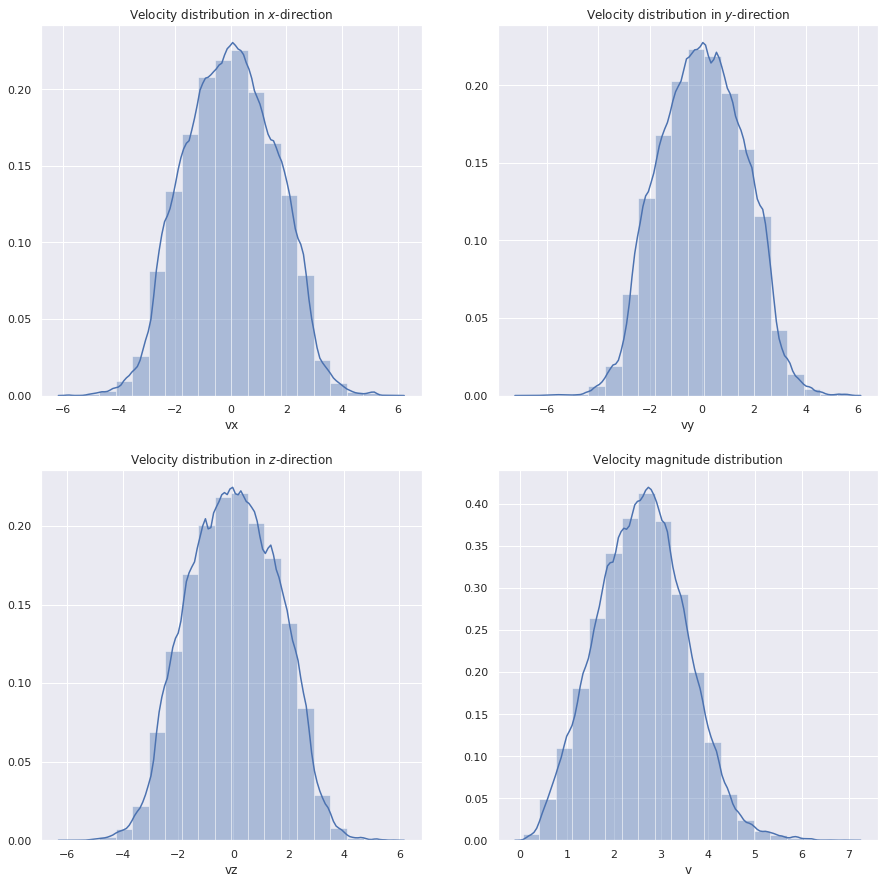

In [42]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
sns.distplot(df.iloc[num_atoms:].vx, bins=num_bins)
plt.title(r"Velocity distribution in $x$-direction")

plt.subplot(2, 2, 2)
sns.distplot(df.iloc[num_atoms:].vy, bins=num_bins)
plt.title(r"Velocity distribution in $y$-direction")

plt.subplot(2, 2, 3)
sns.distplot(df.iloc[num_atoms:].vz, bins=num_bins)
plt.title(r"Velocity distribution in $z$-direction")

plt.subplot(2, 2, 4)
sns.distplot(df.iloc[num_atoms:].v, bins=num_bins)
plt.title(r"Velocity magnitude distribution")

plt.show()

We can now see something that resembles the Maxwell-Boltzmann distribution in the plot over the radial velocity distribution. The individual components $v_x$, $v_y$ and $v_z$ become normally distributed around zero. __(TODO: Expand on this theory: https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution#Distribution_for_the_velocity_vector)__. To determine _when_ we reach something resembling a Maxwell-Boltzmann distribution we will look at the overlap between different histograms as a function of timestep $t_i$. That is, we compute the overlap $o_i$ at timestep $i$ by

\begin{align}
o_i = \frac{\langle h_i, h_n \rangle}{\langle h_n, h_n \rangle},
\end{align}

where $h_i$ is the histogram of a velocity distribution at time $i$.

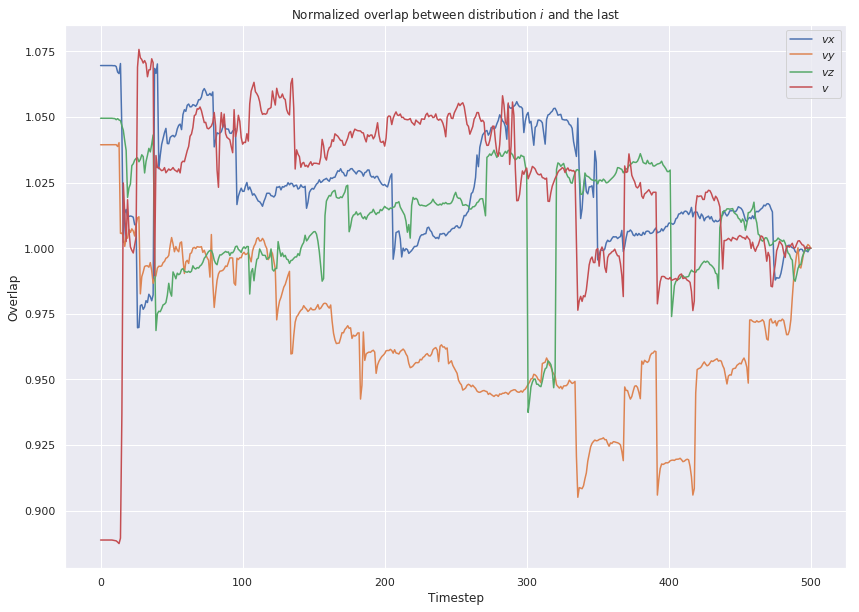

In [80]:
fig = plt.figure(figsize=(14, 10))
timesteps = np.arange(num_timesteps)
last_slice = slice((num_timesteps - 1) * num_atoms, num_timesteps * num_atoms)

for v in ["vx", "vy", "vz", "v"]:
    last_hist, bins = np.histogram(df.loc[last_slice, v], bins=num_bins, density=True)
    norm = np.dot(last_hist, last_hist)
    overlap = np.zeros(num_timesteps)

    for i in range(num_timesteps):
        t_i = slice(i * num_atoms, (i + 1) * num_atoms)
        hist, bins = np.histogram(df.loc[t_i, v], bins=num_bins, density=True)
        overlap[i] = np.dot(hist, last_hist) / norm

    plt.plot(timesteps, overlap, label=fr"${v}$")

plt.legend(loc="best")
plt.xlabel(r"Timestep")
plt.ylabel(r"Overlap")
plt.title(r"Normalized overlap between distribution $i$ and the last")
plt.show()

We can see that the distributions (especially the radial distribution) after quite few timesteps does a sharp jump. The distributions then fluctuate close to zero, before eventually reaching the final distribution which we've deemed close enough to a Maxwell-Boltzmann distribution.

## Energy of the system

We now wish to explore the total energy, $E(t)$, of the system (sum of the kinetic and the potential energy) as a function of time. We are interested in seeing the effect of different timesteps $\Delta t$ to see how the energy fluctuates. We wish the total energy of the system to be conserved over time. Initially we will however see that the energy drops as the system uses some time to thermalize.

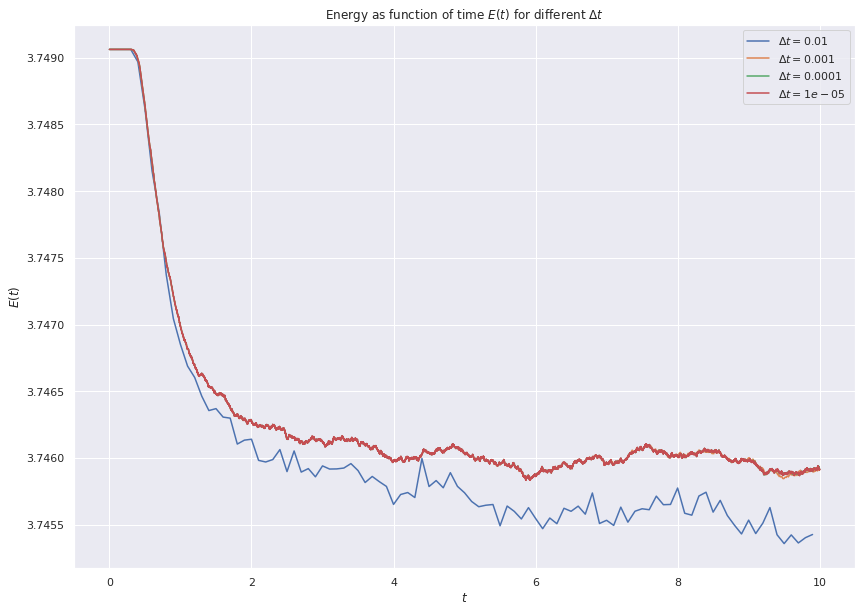

In [105]:
fig = plt.figure(figsize=(14, 10))

for i in range(2, 6):
    dt = 10 ** (-i)
    filename = os.path.join("energy-timestep", f"thermo_{i}.log")
    log_df = pd.read_csv(filename, sep="\s+", skiprows=16, skipfooter=28, engine="python")

    plt.plot(log_df.Step * dt, log_df.TotEng, label=fr"$\Delta t = {dt}$")

plt.title(r"Energy as function of time $E(t)$ for different $\Delta t$")
plt.xlabel(r"$t$")
plt.ylabel(r"$E(t)$")
plt.legend(loc="best")
plt.show()

In this figure we can see how the energy has a distinct drop for all timesteps $\Delta t$. However, for $\Delta t = 0.01$ we notice that the system drops markantly lower than for the lower timesteps. Also, the fluctuations are quite dramatic. These fluctuations are also a result of fewer samples, but the trend still stands.